In [6]:
import tensorflow as tf


from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input ,Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, LeakyReLU

import cv2



In [1]:
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [2]:
train_color_folder="C:\\Users\\sayan\\Desktop\\idk\\datase\\color"
train_black_folder="C:\\Users\\sayan\\Desktop\\idk\\datase\\gray"




In [3]:
buffer_size= 3200
batch_size=16
width=256
height=256

In [14]:
train_color_paths = [os.path.join(train_color_folder, img) for img in os.listdir(train_color_folder)]
train_black_paths = [os.path.join(train_black_folder, img) for img in os.listdir(train_black_folder)]

train_image_pairs = list(zip( train_black_paths,train_color_paths))




In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_image_pairs)


In [16]:

def load_images(black, color):
    black = tf.io.read_file(black)
    black = tf.image.decode_jpeg(black)
    color = tf.io.read_file(color)
    color = tf.image.decode_jpeg(color)

    black = tf.image.resize(black, [height, width])    
    color = tf.image.resize(color, [height, width])

    black = (black / 127.5)-1
    color = (color / 127.5)-1

    return black, color


In [17]:

train_dataset = train_dataset.map(lambda x: load_images(x[0],x[1]))


In [18]:

train_dataset = train_dataset.shuffle(buffer_size=len(train_image_pairs)).batch(batch_size)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)




In [38]:
num_elements = tf.data.experimental.cardinality(train_dataset).numpy()
num_elements

446

In [39]:
train_size = int(0.8 * num_elements)
test_size = int(0.2 * num_elements)
    
train_ds = train_dataset.take(train_size)    
test_dataset = train_dataset.skip(train_size).skip(test_size)

train_dataset=train_ds
    

In [40]:


for batch in train_dataset.take(1):  
    black_images, color_images = batch


In [41]:
color_images.shape,black_images.shape

(TensorShape([16, 256, 256, 3]), TensorShape([16, 256, 256, 1]))

In [42]:
def encoder(layer, filter, batch_norm=True):

    init = RandomNormal(stddev=0.02)

    encode= Conv2D(filter, 4, strides=2, padding='same', kernel_initializer=init)(layer)

    if batch_norm:
        encode=BatchNormalization(momentum=0.8)(encode, training=True)
    
    encode=LeakyReLU(alpha=0.2)(encode)

    return encode
    

In [43]:
def decoder(layer, skip, filter, dropout=True):

    init = RandomNormal(stddev=0.02)

    decode= Conv2DTranspose(filter, 4, strides=2, padding='same', kernel_initializer=init)(layer)

    if dropout:
        decode= Dropout(0.25)(decode, training = True)
    
    decode = BatchNormalization(momentum=0.8)(decode)
    
    decode = Concatenate()([decode, skip])
    
    decode= Activation('relu')(decode)

    return decode

In [44]:
def make_generator():

    init = RandomNormal(stddev=0.02)

    input= Input(shape=[256,256,1])

    e1=encoder(input, 64, batch_norm=False)
    e2=encoder(e1, 128)
    e3=encoder(e2, 256)
    e4=encoder(e3, 512)
    e5=encoder(e4, 512)
    e6=encoder(e5, 512)
    e7=encoder(e6, 512)
    e8=encoder(e7, 512, batch_norm=False)

    b=Activation('relu')(e8)

    d1= decoder(b, e7, 512)
    d2= decoder(d1, e6, 512)
    d3= decoder(d2, e5, 512)
    d4= decoder(d3, e4, 512, dropout=False)
    d5= decoder(d4, e3, 256, dropout=False)
    d6= decoder(d5, e2, 128, dropout=False)
    d7= decoder(d6, e1, 64, dropout=False)
    
    out=Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=init, activation= 'tanh')(d7)

    model=Model(inputs=input, outputs=out)
    return model

    

    

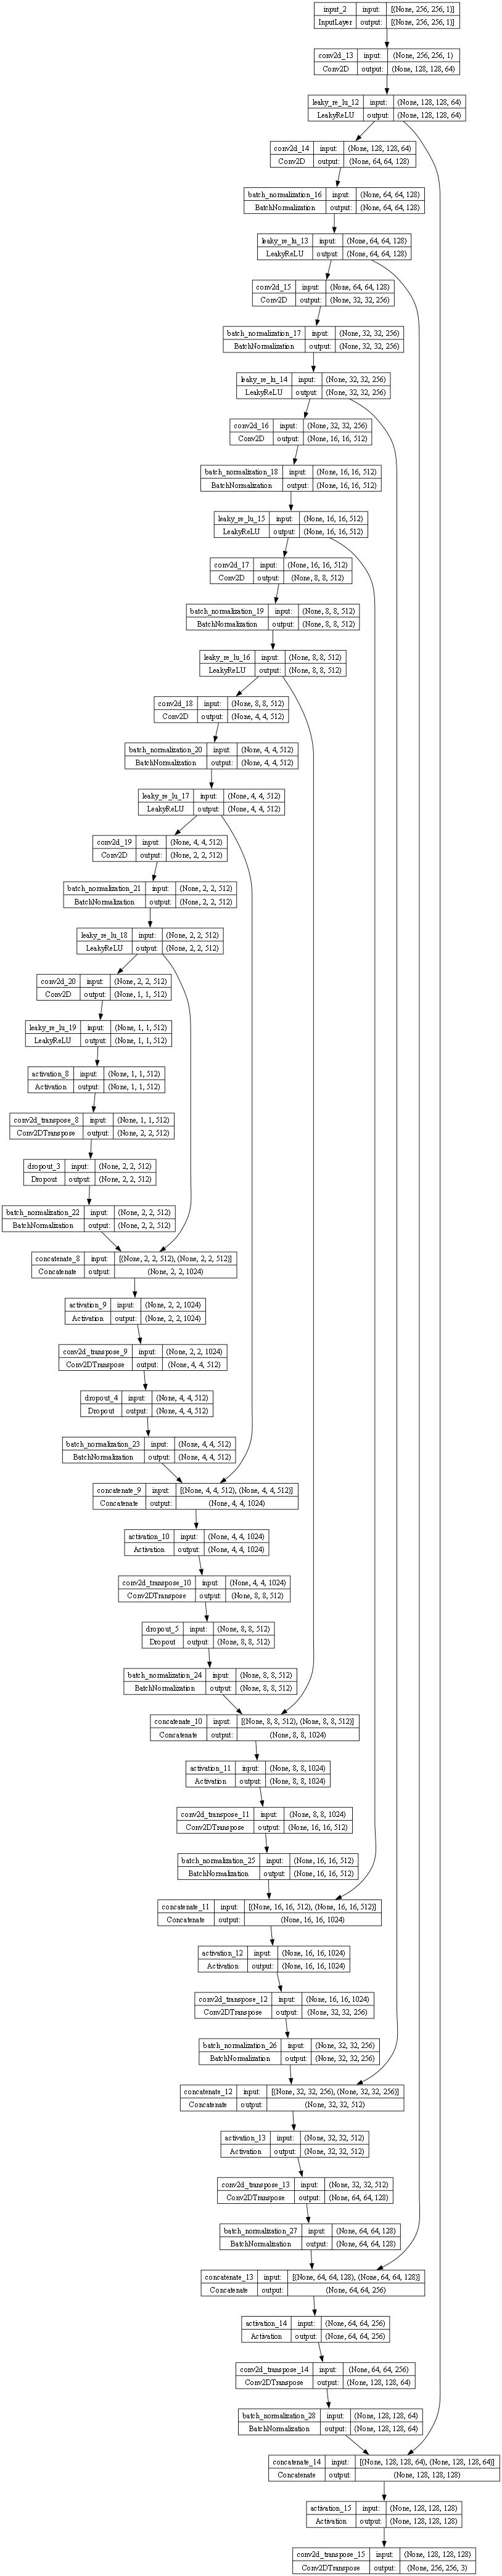

In [45]:
generator = make_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [46]:
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 64  1088        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_13[0][0]']              
                                )                                                           

In [47]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (100 * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [48]:
def make_discriminator():

    init=RandomNormal(stddev=0.02)

    input=Input(shape=[256,256,1], name='input')
    target=Input(shape=[256,256,3], name='target')

    x=Concatenate()([input,target])

    e1=encoder(x, 64, batch_norm=False)
    e2=encoder(e1, 128)
    e3=encoder(e2, 256)

    zero_pad=tf.keras.layers.ZeroPadding2D()(e3)
    conv=Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad)
    batchnorm=BatchNormalization(momentum=0.8)(conv)
    leakyrelu=LeakyReLU(alpha=0.2)(batchnorm)
    zero_pad=tf.keras.layers.ZeroPadding2D()(leakyrelu)

    out=Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad)

    return Model(inputs=[input,target], outputs=out)


c:\Users\sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


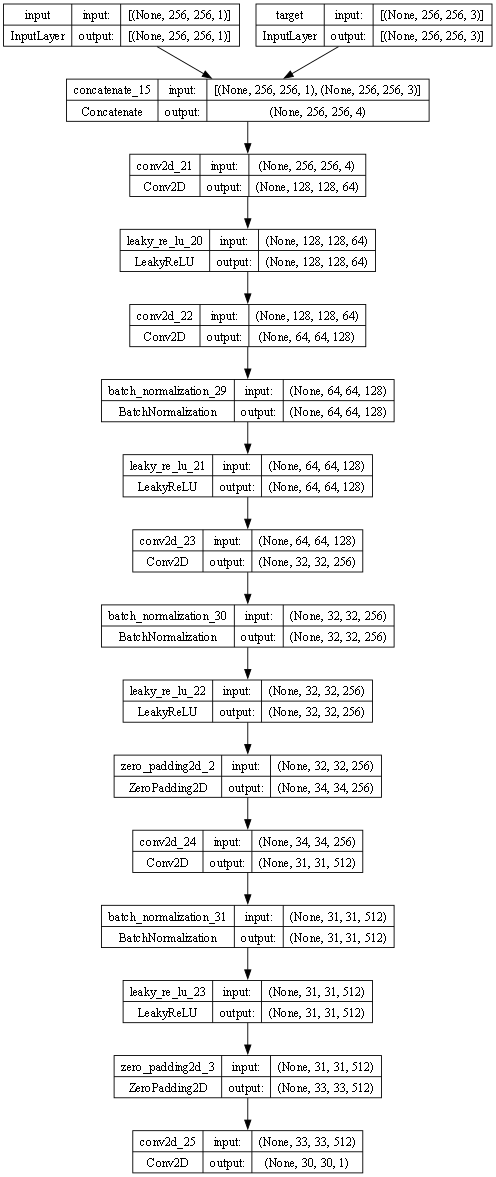

In [49]:
discriminator = make_discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [50]:
def discriminator_loss(real, generated):
  real_loss = loss_object(tf.ones_like(real), real)

  generated_loss = loss_object(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [51]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [52]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [53]:
def generate(model, input, target):

    prediction=model(input, training= True)
    plt.figure(figsize=(16,16))

    display=[tf.image.grayscale_to_rgb(input[0]), target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
     plt.subplot(1, 3, i+1)
     plt.title(title[i])
     plt.imshow(display[i] * 0.5 + 0.5)
     plt.axis('off')
    plt.show()





In [54]:
@tf.function
def train(image, target, step):
    with tf.GradientTape() as gtape, tf.GradientTape() as dtape:

        generated_image=generator(image,training=True)

        real=discriminator([image,target], training=True)
        fake=discriminator([image,generated_image], training=True)

        gen_loss,_,_=generator_loss(fake, generated_image, target)
        disc_loss = discriminator_loss(real, fake)

    gradients_of_generator = gtape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = dtape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [55]:
def fit(train_ds, test_ds, epochs):
  example_input, example_target = next(iter(test_ds.take(400)))
  start = time.time()

  for epoch, (input_image, target) in train_ds.repeat().take(epochs).enumerate():
    if epoch % 1000 == 0:
      display.clear_output(wait=True)

      if epoch != 0:
        print(f'Time taken for 1000 epochs: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate(generator, example_input, example_target)
      print(f"Epoch: {epoch//1000}k")

    train(input_image, target, epoch)

    # Training step
    if (epoch+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (epoch + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 epochs: 318.67 sec



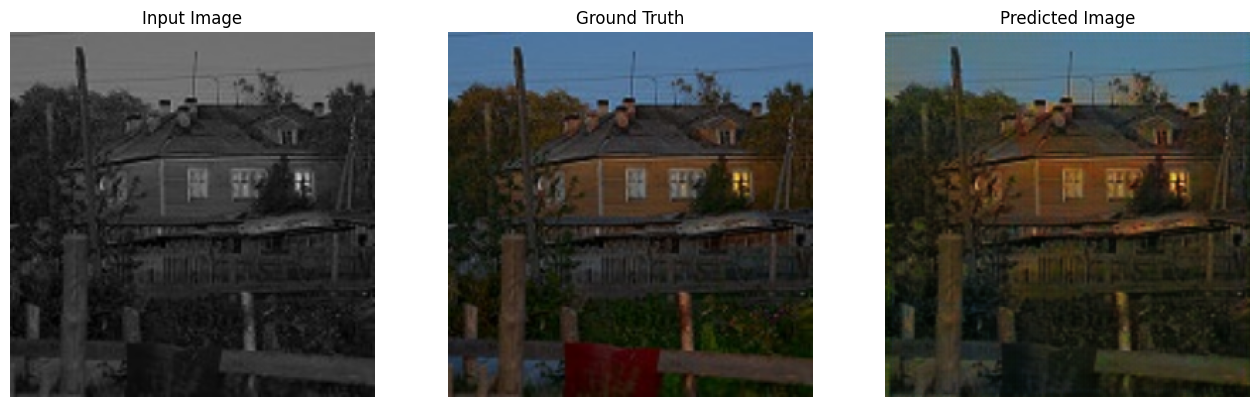

Epoch: 14k
....................................................................................................

In [56]:
fit(train_dataset, test_dataset,  epochs=15000)

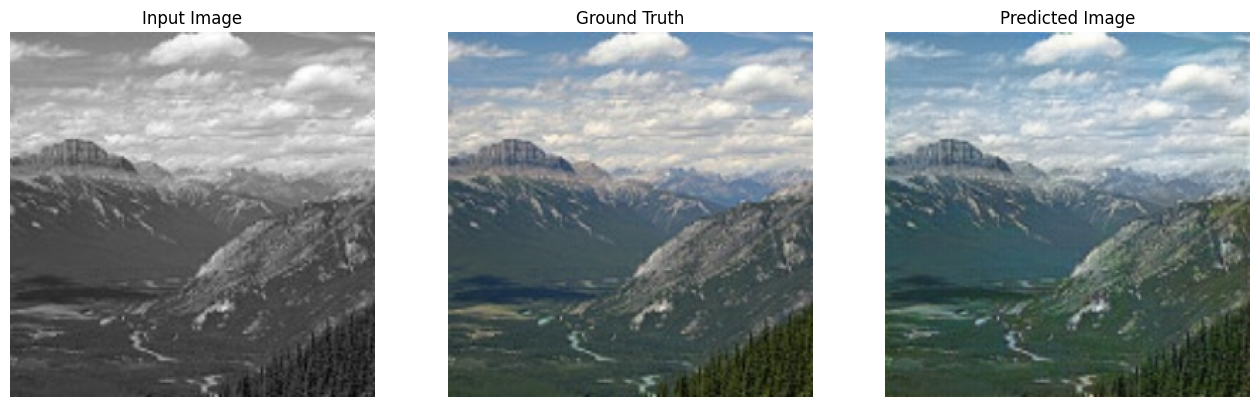

In [65]:
for inp, tar in test_dataset.take(10):
  generate(generator, inp, tar)

In [61]:
l=generator.save('pix2piximage')

INFO:tensorflow:Assets written to: pix2piximage\assets


INFO:tensorflow:Assets written to: pix2piximage\assets


In [63]:
generator.save('pix2piximage.h5')